## Workflow to analyze Photometry data

### Imports

In [1]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *

        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


### Variables
- A tasks definition file (.csv) contains all the information to perform the extractions of behaviorally relevant information from **PyControl** files, for each **task** file. It includes what are the **triggers** of different trial types, what **events** to extract (with time data), and what are events or printed lines that could be relevant to determine the **conditions** (e.g: free reward, optogenetic stimulation type, etc.)

In [11]:
import pandas as pd

trial_window = [-2000, 6000] # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 4000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.getcwd())

# These must be absolute path
tasksfile = r'params\tasks_params.csv'
photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'

# To analyze a new task you need to append task characteristics
# like task filename, triggers, events and opto_categories print events
tasks = pd.read_csv(os.path.join(basefolder,tasksfile), usecols = [1,2,3,4], index_col = False)
tasks

,task,triggers,events,conditions
0,lick_go_nogo,go; nogo,bar; bar_off; spout,free_reward
1,lick_go_nogo_unconditionned,go; nogo,bar; bar_off; spout,free_reward
2,lick_go_nogo_unconditionned_opto,go; nogo,bar; bar_off; spout,free_reward
3,reaching_go_nogo,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
4,reaching_go_nogo_jc,CS_plus; CS_minus,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
5,reaching_go_nogo_opto_continuous,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset; s_go_sham; s_go_...
6,reaching_go_nogo_opto_sinusoid,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
7,reaching_go_nogo_opto_sinusoid_spout,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
8,reaching_go_nogo_reversal,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
9,reaching_go_nogo_reversal_incentive,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...


In [9]:
head, tail = os.path.split(os.getcwd())
head
tail

'notebooks'

In [110]:
tasks.iloc[4,:].conditions

'error bar_off; reward bar_off; error free; reward free; button_press'

### Create an experiment object

This will include all the pycontrol files present in the folder_path directory (do not include subdirectories)

In [3]:
# Folder of a full experimental batch, all animals included
folder_path = r'T:\Data\head-fixed\test_folder\pycontrol'
# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(folder_path)

# Only use if the Experiment cohort as been processed by trials before
exp_cohort.by_trial = True

Saved sessions loaded from: sessions.pkl


### Perform extraction of behavioural information by trial

In [ ]:
# Process the whole experimental folder by trials
exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile)

# Save the file as sessions.pkl in folder_path
exp_cohort.save()

### Match with photometry, videos, and DeepLabCut files

In [ ]:
# Find if there is a matching photometry file and if it can be used:
# rsync synchronization pulses matching between behaviour and photometry
exp_cohort.match_to_photometry_files(photometry_dir, rsync_chan, verbose=False)

# Find matching videos
exp_cohort.match_sessions_to_files(video_dir, ext='mp4')

# FInd matching DeepLabCut outputs files
exp_cohort.match_sessions_to_files(video_dir, ext='h5')

exp_cohort.save()


### Define conditions and groups for extraction

In [4]:
# Defime each trial type as a dictionary of conditions to be met
conditions_dict1 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': False, 'reward free': False, 'button_press': False}
conditions_dict2 = {'trigger': 'CS_Go', 'valid': True, 'success': False, 'reward free': False, 'button_press': False}
conditions_dict3 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': True, 'reward free': False, 'button_press': False}
conditions_dict4 = {'trigger': 'CS_NoGo', 'valid': True, 'success': True, 'button_press': False}
conditions_dict5 = {'trigger': 'CS_NoGo', 'valid': True, 'success': False, 'button_press': False}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict1, conditions_dict2, conditions_dict3, conditions_dict4, conditions_dict5]
# Aliases for conditions
cond_aliases = ['Go hit', 'Go miss', 'Go hit error', 'NoGo hit', 'NoGo miss']
# Groups as a list of lists
groups = [[280, 281, 282, 289],[295, 282, 284, 285, 292, 297]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]

### Extract Photometry trials and create a Continuous_Dataset

In [26]:
cont_dataset = exp_cohort.get_photometry_groups(
        groups = [300], # or use groups variable defined above
        conditions_list = condition_list, 
        cond_aliases = cond_aliases, 
        when = 'all', 
        task_names = 'reaching_go_nogo',
        trig_on_ev = 'spout', # align to the first event of a kind e.g. bar_off
        high_pass = None, 
        low_pass = 30, 
        median_filt = 15,
        motion_corr = True, 
        df_over_f = True, 
        downsampling_factor = 10, 
        export_vars = ['analog_1','analog_1_filt','analog_2','analog_2_filt','analog_1_df_over_f'], 
        verbose = False)

cont_dataset.set_trial_window(trial_window, 'ms')


No trial in any condition for subject 300 at: 2022-06-27 14:32:03


In [16]:
cont_dataset.conditions

[{'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': False},
 {'trigger': 'CS_Go', 'valid': True, 'success': False},
 {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': True},
 {'trigger': 'CS_NoGo', 'valid': True, 'success': True},
 {'trigger': 'CS_NoGo', 'valid': True, 'success': False}]

### Save Photometry Dataset

In [17]:
folder_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs'
cont_dataset.save(folder_path, 'photo_go_nogo_mf15_lp30_gonogo_with_error_trials')

Dataset saved in C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\photo_go_nogo_mf15_lp30_gonogo_with_error_trials.pkl
data size is 499.48133087158203 Mb


### Reload a pre-existing dataset

In [5]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\photo_go_nogo_mf15_lp30_bar_off.pkl'
cont_dataset = load_dataset(dataset_full_path)

### Optional methods

In [6]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 7)

# To remove subjects who do not have
# trials in all the conditions
cont_dataset.filter_if_not_in_all_cond()


### Plot the photometry by condition

 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


IndexError: Too many levels: Index has only 1 level, not 3

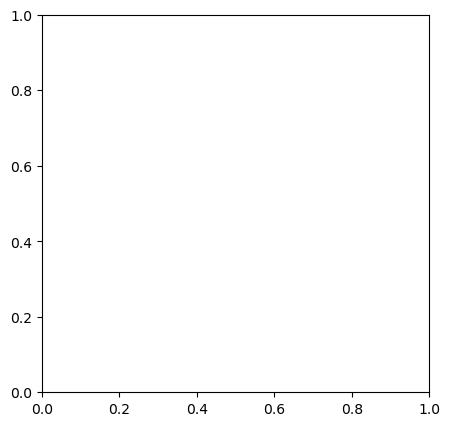

In [7]:
# if this was not set at creation
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-200, 600],
    time_unit = 'milliseconds',
    ylim =  None,# [[-0.004, 0.006]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    error = None,
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5, 5),
    dpi = 100,
    verbose = True)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()



In [87]:
cont_dataset.get_groups()

array([array([280, 282, 289, 290, 291, 292, 293, 294, 295, 296, 297, 299, 300,
              301, 303, 304, 305, 306, 307], dtype=int64)                     ],
      dtype=object)

### Optional methods

In [303]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 1)

# To remove subjects who do not have
# trials in all the conditions
cont_dataset.filter_if_not_in_all_cond()


 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


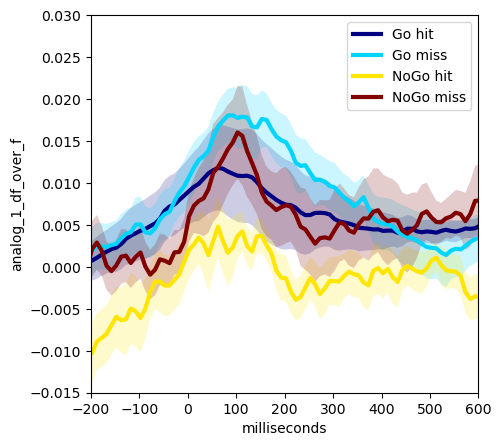

In [304]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-200, 600],
    time_unit = 'milliseconds',
    ylim = [[-0.015, 0.03]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5, 5),
    dpi = 100,
    verbose = False)


In [305]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\photo_go_nogo_mf15_lp30_bar_off.pkl'
cont_dataset = load_dataset(dataset_full_path)

### Optional methods

In [306]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 1)

# To remove subjects who do not have
# trials in all the conditions
cont_dataset.filter_if_not_in_all_cond()


 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


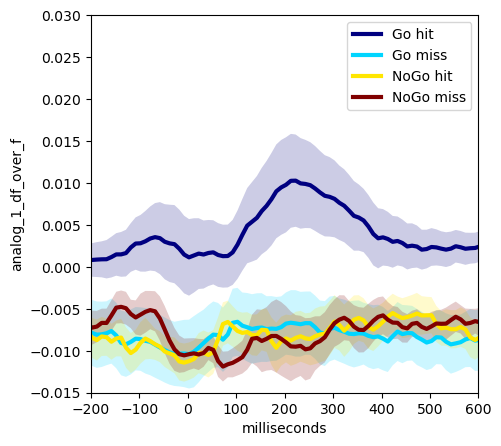

In [307]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-200, 600],
    time_unit = 'milliseconds',
    ylim = [[-0.015, 0.03]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5, 5),
    dpi = 100,
    verbose = False)
